## 1. Fundamental frequency estimation by eye

In [110]:
import librosa
import sounddevice
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14, 5)

### a) Load

In [79]:
s1 = librosa.core.load("speech1.wav", sr=None)
s2 = librosa.core.load("speech2.wav", sr=None)

In [80]:
s1, s2

((array([1.2207031e-04, 9.1552734e-05, 1.8310547e-04, ..., 9.1552734e-05,
         1.2207031e-04, 1.2207031e-04], dtype=float32),
  16000),
 (array([ 7.0190430e-04, -2.4414062e-04,  1.2207031e-04, ...,
         -3.0517578e-05,  3.0517578e-05,  3.0517578e-05], dtype=float32),
  16000))

The sampling frequency is 16 000 Hz

In [81]:
sampling_freq = 16000

### b) Plot

In [82]:
def plot_signal(signal, sampling_freq, title):
    time = np.arange(signal.shape[0]) / sampling_freq
    plt.plot(time, signal)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.show()

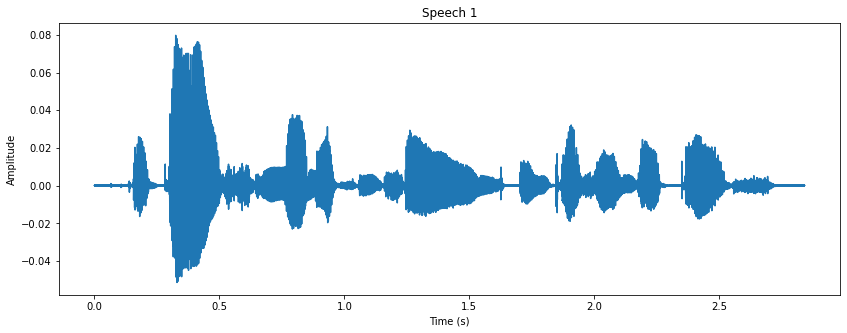

In [83]:
plot_signal(s1[0], sampling_freq, "Speech 1")

Silence corresponds to the parts with amplitude near zero.

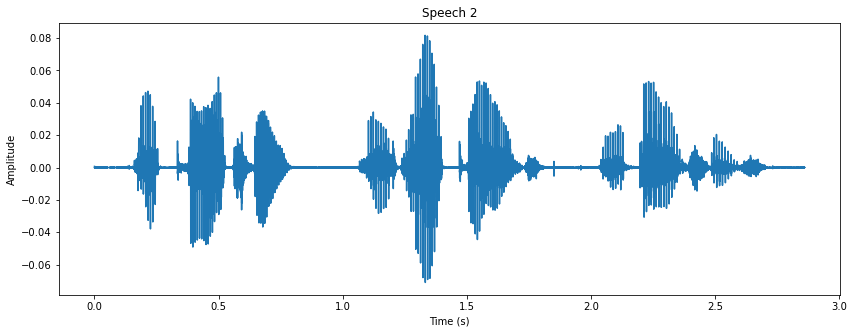

In [84]:
plot_signal(s2[0], sampling_freq, "Speech 2")

### 3) Fundamental frequency estimation

In [145]:
# select a segment from both signals
s1_seg = s1[0][5200:5500]
s2_seg = s2[0][24800:25100]

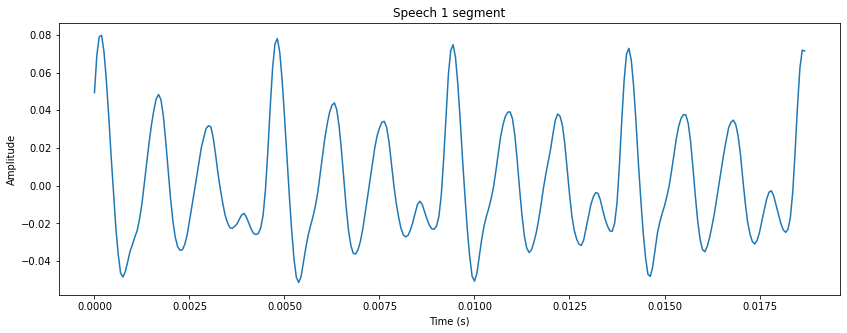

In [146]:
plot_signal(s1_seg, sampling_freq, "Speech 1 segment")

In [148]:
print(f"Fundamental freq of signal 1: {1 / (0.01 - 0.005)}")

Fundamental freq of signal 1: 200.0


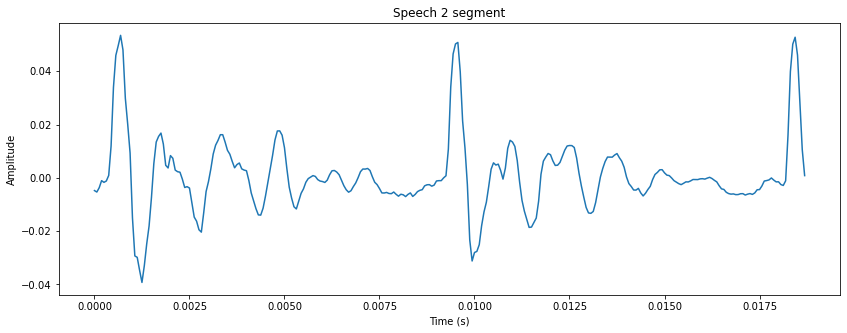

In [149]:
plot_signal(s2_seg, sampling_freq, "Speech 2 segment")

In [151]:
print(f"Fundamental freq of signal 1: {1 / (0.01 - 0.0005)}")

Fundamental freq of signal 1: 105.26315789473685


The fundamental frequency of signal 1 is about 200 Hz, and the fundamental frequency of signal 2 is about 100 Hz. This suggests that signal 1 belongs to a female speaker, while signal 2 is from a male speaker.